# EDA: FDOT Work Program Construction Data

Exploratory data analysis for **risk scoring** feasibility. Focus: schema, missingness, feature variance, distributions, correlations, and geospatial context.


In [11]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path

# Project root (run from repo root or from analysis/)
ROOT = Path("..").resolve() if Path(".").resolve().name == "analysis" else Path(".").resolve()
DATA_PATH = ROOT / "data" / "processed" / "fdot_work_program_construction.gpkg"
assert DATA_PATH.exists(), f"Data not found: {DATA_PATH}. Run ingest first."
print(f"Data path: {DATA_PATH}")

Data path: /home/trevor/repos/CAP_3764_2026_Spring_Team_1/data/processed/fdot_work_program_construction.gpkg


In [12]:
gdf = gpd.read_file(DATA_PATH)
print(f"Shape: {gdf.shape}")
print(f"CRS: {gdf.crs}")
gdf.head(3)

Shape: (6820, 28)
CRS: EPSG:4326


,OBJECTID,WPITEM,WPITMSEG,ITMSEG,FINPROJ,RDWYLOC,BEGSECPT,ENDSECPT,RDWYSIDE,RDWYID,...,FISCALYR,PRPLCCDE,PRPLCODE,CONTYNAM,WPWKMIXN,WPITSTNM,LOCALFULL,LOC_ERROR,Shape__Length,geometry
0,36580,251156,3,2511563,25115635201,2,0.00,0.496,C,87059000,...,2029,A,03,MIAMI-DADE,NEW ROAD CONSTRUCTIO,CONST.COMPLETE,PORT OF MIAMI TUNNEL FROM PORT OF MIAMI TO SR ...,NO ERROR,797.883575,"LINESTRING (-80.17689 25.78677, -80.17653 25.7..."
1,36584,251688,1,2516881,25168815209,7,0.01,0.133,C,87200119,...,2026,A,01,MIAMI-DADE,BRIDGE-REPLACE AND A,UNDER CONSTRUCTION,SR 836/I-395 FROM WEST OF I-95 TO MACARTHUR CS...,NO ERROR,198.740872,"LINESTRING (-80.20079 25.7891, -80.20104 25.78..."
2,36585,251688,1,2516881,25168815204,5,0.00,0.102,C,87200123,...,2025,A,01,MIAMI-DADE,BRIDGE-REPLACE AND A,UNDER CONSTRUCTION,SR 836/I-395 FROM WEST OF I-95 TO MACARTHUR CS...,NO ERROR,170.858574,"LINESTRING (-80.19375 25.78592, -80.19314 25.7..."


## 1. Schema & data quality

Columns, dtypes, missingness, duplicates, geometry checks.

In [13]:
# Schema
print("Columns and dtypes:")
print(gdf.dtypes)

# Missingness
missing = gdf.isnull().sum()
missing_pct = (missing / len(gdf) * 100).round(2)
missing_df = pd.DataFrame({"missing": missing, "pct": missing_pct})
print("\nMissingness (columns with any missing):")
print(missing_df[missing_df["missing"] > 0].sort_values("pct", ascending=False))

# Duplicates on key ID (if applicable)
if "OBJECTID" in gdf.columns:
    dup = gdf["OBJECTID"].duplicated().sum()
    print(f"\nDuplicate OBJECTID: {dup}")

# Geometry
print(f"\nEmpty geometries: {gdf.geometry.is_empty.sum()}")
print(f"Null geometries: {gdf.geometry.isna().sum()}")

Columns and dtypes:
OBJECTID            int64
WPITEM                str
WPITMSEG              str
ITMSEG                str
FINPROJ               str
RDWYLOC             int64
BEGSECPT          float64
ENDSECPT          float64
RDWYSIDE              str
RDWYID                str
ITSEGMAN              str
WPWKMIX               str
WPITSTAT              str
MANDISDV              str
CONTYDOT              str
WPPHAZGP              str
WPPHAZTP              str
FINPRJSQ              str
FISCALYR            int64
PRPLCCDE              str
PRPLCODE              str
CONTYNAM              str
WPWKMIXN              str
WPITSTNM              str
LOCALFULL             str
LOC_ERROR             str
Shape__Length     float64
geometry         geometry
dtype: object

Missingness (columns with any missing):
Empty DataFrame
Columns: [missing, pct]
Index: []

Duplicate OBJECTID: 0

Empty geometries: 0
Null geometries: 0


## 2. Feature variance & distribution quality

Categorical value counts; numeric describe + variance; flag near-zero variance.

In [14]:
# Separate candidate feature columns (exclude geometry and pure IDs for variance check)
exclude = {"geometry", "OBJECTID", "WPITEM", "ITMSEG", "FINPROJ", "RDWYID", "LOCALFULL"}
cols = [c for c in gdf.columns if c not in exclude]

categoricals = gdf[cols].select_dtypes(include=["object", "category"]).columns.tolist()
numerics = gdf[cols].select_dtypes(include=[np.number]).columns.tolist()
print("Categoricals:", categoricals)
print("Numerics:", numerics)

Categoricals: ['WPITMSEG', 'RDWYSIDE', 'ITSEGMAN', 'WPWKMIX', 'WPITSTAT', 'MANDISDV', 'CONTYDOT', 'WPPHAZGP', 'WPPHAZTP', 'FINPRJSQ', 'PRPLCCDE', 'PRPLCODE', 'CONTYNAM', 'WPWKMIXN', 'WPITSTNM', 'LOC_ERROR']
Numerics: ['RDWYLOC', 'BEGSECPT', 'ENDSECPT', 'FISCALYR', 'Shape__Length']


/tmp/ipykernel_13236/883864315.py:5: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categoricals = gdf[cols].select_dtypes(include=["object", "category"]).columns.tolist()


In [15]:
# Categorical: value counts and cardinality
for col in categoricals[:10]:  # first 10
    n = gdf[col].nunique()
    print(f"{col}: n_unique={n}")
    print(gdf[col].value_counts(dropna=False).head(5))
    print("---")

WPITMSEG: n_unique=9
WPITMSEG
1    4784
2     723
3     453
5     362
4     338
Name: count, dtype: int64
---
RDWYSIDE: n_unique=3
RDWYSIDE
C    3979
R    1569
L    1272
Name: count, dtype: int64
---
ITSEGMAN: n_unique=54
ITSEGMAN
BENITEZ, AURALIZ        1048
FUNTANELLAS, IVETTE      901
QUINTELA, RAUL           813
BECK-GALINDO, J.         432
LEON, KIRA               387
Name: count, dtype: int64
---
WPWKMIX: n_unique=45
WPWKMIX
0012    1821
0213     856
0023     627
0229     550
0756     476
Name: count, dtype: int64
---
WPITSTAT: n_unique=14
WPITSTAT
090    2782
096    1497
100     677
010     552
070     516
Name: count, dtype: int64
---
MANDISDV: n_unique=2
MANDISDV
06    6457
08     363
Name: count, dtype: int64
---
CONTYDOT: n_unique=1
CONTYDOT
87    6820
Name: count, dtype: int64
---
WPPHAZGP: n_unique=1
WPPHAZGP
5    6820
Name: count, dtype: int64
---
WPPHAZTP: n_unique=7
WPPHAZTP
2    4654
6     678
A     558
8     375
7     336
Name: count, dtype: int64
---
FINPRJSQ: n_uniq

In [7]:
# Numeric: describe + variance (std)
if numerics:
    print(gdf[numerics].describe())
    print("\nStd (variance proxy) - flag near-zero:")
    print(gdf[numerics].std())

           RDWYLOC     BEGSECPT     ENDSECPT     FISCALYR  Shape__Length
count  6820.000000  6820.000000  6820.000000  6820.000000    6820.000000
mean     10.047947     5.493932     5.900000  2025.150147     653.212572
std       9.985877     8.375675     8.567876     1.708233    1102.883114
min       2.000000     0.000000     0.001000  2023.000000       1.586149
25%       3.000000     0.090000     0.246000  2024.000000     106.097193
50%       7.000000     1.168000     1.582000  2025.000000     238.436300
75%      13.000000     8.632000     9.086000  2026.000000     674.081817
max      65.000000    39.716999    40.150002  2030.000000   11982.310208

Std (variance proxy) - flag near-zero:
RDWYLOC             9.985877
BEGSECPT            8.375675
ENDSECPT            8.567876
FISCALYR            1.708233
Shape__Length    1102.883114
dtype: float64


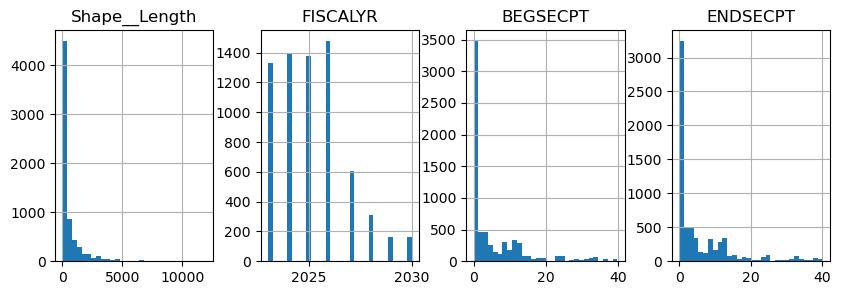

In [8]:
# Quick distributions: key numerics (sample)
key_numeric = [c for c in ["Shape__Length", "FISCALYR", "BEGSECPT", "ENDSECPT"] if c in gdf.columns]
if key_numeric:
    gdf[key_numeric].hist(bins=30, figsize=(10, 3), layout=(1, len(key_numeric)));

## 3. Correlations (numeric)

Correlation matrix; flag strong correlations for multicollinearity.

In [9]:
if len(numerics) > 1:
    corr = gdf[numerics].corr()
    display(corr)
    # Strong pairs (|r| > 0.8)
    for i in range(len(corr.columns)):
        for j in range(i + 1, len(corr.columns)):
            r = corr.iloc[i, j]
            if abs(r) > 0.8:
                print(f"Strong correlation: {corr.columns[i]} vs {corr.columns[j]} = {r:.3f}")

,RDWYLOC,BEGSECPT,ENDSECPT,FISCALYR,Shape__Length
RDWYLOC,1.000000,-0.078529,-0.094814,0.022626,-0.225555
BEGSECPT,-0.078529,1.000000,0.996981,0.004975,0.242500
ENDSECPT,-0.094814,0.996981,1.000000,0.001507,0.317094
FISCALYR,0.022626,0.004975,0.001507,1.000000,-0.041963
Shape__Length,-0.225555,0.242500,0.317094,-0.041963,1.000000


Strong correlation: BEGSECPT vs ENDSECPT = 0.997


## 4. Geospatial

Bounds, extent, optional simple map.

Bounds: [-80.76970388  25.29209429 -80.12020202  25.97444119]
CRS: EPSG:4326


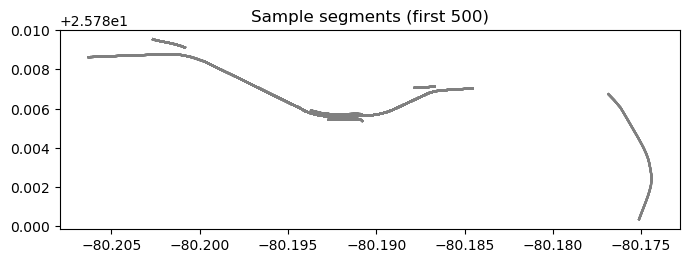

In [10]:
print("Bounds:", gdf.total_bounds)
print("CRS:", gdf.crs)

# Simple map (first 500 segments to keep small)
ax = gdf.head(500).plot(figsize=(8, 8), alpha=0.5, edgecolor="gray")
ax.set_title("Sample segments (first 500)");

## Next steps

1. **Define risk**: Supervised (need target) vs unsupervised (feature-only proxy). 
2. **Feature set**: Drop or transform low-variance, high-missing, or redundant columns; encode categoricals.